<a href="https://colab.research.google.com/github/mvera1412/TOA_causal/blob/test-mati-p/notebooks/TUPAC_toa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
in_colab = True # save to notebooks/TUPAC_toa.ipynb
if in_colab:
    from google.colab import output, drive
    drive.mount('/content/drive')  # sets the google drive folder as the notebook directory.
    %cd drive/My Drive/Tesis notebooks/TOA_causal
    print("Currently in /content/drive/My Drive/Tesis notebooks/TOA_causal")
    print("Commit to notebooks/TUPAC_toa.ipynb")
else:
    %cd ~/TOA_causal

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
[Errno 2] No such file or directory: 'drive/My Drive/Tesis notebooks/TOA_causal'
/content/drive/My Drive/Tesis notebooks/TOA_causal
Currently in /content/drive/My Drive/Tesis notebooks/TOA_causal
Commit to notebooks/TUPAC_toa.ipynb


In [ ]:
#from synthetic.createdata import create_trainatestdata
#create_trainatestdata('../data/')

In [115]:
import torch
import os
import uuid
from tqdm import tqdm
from typing import Tuple, List
import numpy as np
import matplotlib.pyplot as plt
from TOA.mbfdunetln import MBPFDUNet
from torch.optim.lr_scheduler import MultiStepLR
from TOA.train import createForwMat
from utils.causal_utils import train,validation,testing,computing_metrics,load_traindataset,load_testdataset,load_ckp
from utils.noncausal_utils import load_traindataset_nc,train_nc

from utils.causal_utils import predicting
from torch.utils.data.dataloader import DataLoader

In [6]:
val_percent = 440.0/2216.0 # 440 para validacion, 1776 para train
le = 5
epochs = 100
# cache_dir = '../data/'
cache_dir = 'datos_toa'
fecha = '120822_17'
#continue_training = False

In [18]:
def save_model(model: torch.nn.Module, name, drive_path='COLAB/colab_models'):
    """Save model parameters to mounted drive folder. To current file location it is appended drive_path/name
    Example:
            dummy_model = MBPFDUNet().to(device=device)
            save_model(dummy_model, name='my_model')
    """
    path = os.path.join(drive_path, name)
    print(f'Saving model to {path} with name "{name}"')
    torch.save(model.state_dict(), path)

def load_model(model: torch.nn.Module, name, drive_path='COLAB/colab_models', device='gpu'):
    path = os.path.join(os.getcwd(),
                        drive_path,
                        name)
    model.load_state_dict(torch.load(path, map_location=torch.device(device)))


# to try out later:
# !git clone https://github.com/yourusername/yourpublicrepo.git

In [8]:
if torch.cuda.is_available():
	device = torch.device("cuda")
else:
	device = torch.device("cpu")
print(f"Device to be used: {device}")


##Loss
loss_fn = torch.nn.MSELoss()

##TOA matrix
Ao = createForwMat()
Ao = torch.as_tensor(Ao).type(torch.float32)
Ao = Ao.to(device=device)

##Files
ckp_last = cache_dir + 'mbfdunetln' + fecha + '.pth' # name of the file of the saved weights of the trained net
ckp_best = cache_dir + 'mbfdunetln_best' + fecha + '.pth'

#if continue_training:
#	model, optimizer, epoch0, valid_loss_min = load_ckp(ckp_last, model, optimizer)
#    lr_scheduler = MultiStepLR(optimizer,milestones=[le * epochs * 3 // 4],gamma=0.1,last_epoch = epoch0 - 1)
#else:
	#epoch0 = 0
	#valid_loss_min = np.inf

Device to be used: cpu
Creating Forward Model-based Matrix without position uncertainty
Creating SIR Matrix...


100%|██████████| 16384/16384 [00:02<00:00, 6793.54it/s]


Creating PA Matrix...
Applying Time Derivative Operator...
done
done


In [116]:
model = MBPFDUNet().to(device=device)
load_model(model, name='MBPFDUNet_bs_[10]_epo_100_lr_0.0005_tau_0.8', device=device.type)

loaders: Tuple[List[DataLoader]] = load_traindataset(cache_dir,val_percent,train_batchsize=10,val_batchsize=40,le = le)
train_loaders, val_loaders = loaders

Feature batch shape: torch.Size([10, 32, 512])
Labels batch shape: torch.Size([10, 64, 64])
Reconstructed batch shape: torch.Size([10, 64, 64])


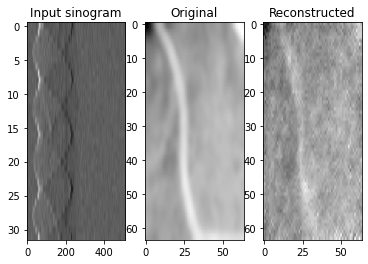

In [117]:
features_and_labels: Tuple[torch.Tensor, torch.Tensor] = next(iter(train_loaders[4]))  # next(iter()) returns the next item to be iterated

train_features, train_labels = features_and_labels
output: torch.Tensor = predicting(model, train_features, Ao, device)

print(f"Feature batch shape: {train_features.size()}")  # size: (batchsize, n_sensors, width) = (10, 32, 512)
print(f"Labels batch shape: {train_labels.size()}")     # size: (batchsize, heigth,    width) = (10, 64, 64)
print(f"Reconstructed batch shape: {output.size()}")    # size: (batchsize, heigth,    width) = (10, 64, 64)
img = train_features[0].squeeze()
label = train_labels[0].squeeze()
reconstructed = output[0].squeeze()

# Plots
figsize = None #(6,6)
fig, axs = plt.subplots(1, 3, figsize=figsize)

axs[0].imshow(img, cmap="gray", aspect='auto')
axs[0].set_title('Input sinogram')

axs[1].imshow(label, cmap="gray", aspect='auto')
axs[1].set_title('Original')

axs[2].imshow(reconstructed.detach(), cmap="gray", aspect='auto')
axs[2].set_title('Reconstructed')
plt.show()

In [62]:
output.size()

torch.Size([10, 64, 64])

In [39]:
from math import tau
"""alphas = [1e-4,5e-4,1e-3]
bs = [1,2,3] # per environment
taus = [0.4,0.8]"""
alphas = [5e-4]
bs = [10] # per environment
taus = [0.4]

checkpoint = {'valid_loss_min': np.inf}

epoch0 = 0
for batchsize in bs:
    train_loaders, val_loader = load_traindataset(cache_dir,val_percent,batchsize,val_batchsize=40,le = le)
    for lr in alphas:
        for agreement_threshold in taus:
            model = MBPFDUNet().to(device=device)
            checkpoint['state_dict'] = model.state_dict()
            optimizer = torch.optim.Adam(model.parameters(),lr=lr)
            checkpoint['learning_rate'] = lr
            checkpoint['batchsize'] = batchsize
            checkpoint['agreement_threshold'] = agreement_threshold
            checkpoint['optimizer'] = optimizer.state_dict()
            checkpoint['epoch'] = epoch0
            lr_scheduler = MultiStepLR(optimizer,milestones=[le * epochs * 3 // 4],gamma=0.1)
            for epoch in tqdm(range(epoch0 + 1, epochs + 1)):
                train(model,device,train_loaders,optimizer,n_agreement_envs=le,Ao=Ao,loss_fn=loss_fn,agreement_threshold=agreement_threshold,scheduler=lr_scheduler)
                checkpoint['epoch'] = epoch
                checkpoint['valid_loss_min'] = validation(model, device, val_loader, optimizer, loss_fn, Ao, checkpoint, ckp_last, ckp_best, fecha)
            if in_colab:
                name = f"MBPFDUNet_bs_{batchsize}_epo_{epochs}_lr_{lr}_tau_{agreement_threshold}"
                name += "_" + str(uuid.uuid1())[:5]
                save_model(model, name=name)

KeyboardInterrupt: ignored

In [ ]:
model, optimizer, best_epoch, valid_loss_min, best_lr, best_bs, best_threshold = load_ckp(ckp_best, model, optimizer)

In [ ]:
#from importlib import reload 
#import utils.noncausal_utils 
#reload(utils.noncausal_utils)
#from utils.noncausal_utils import train_nc

In [ ]:
alphas = [5e-4]
bs = [10] # per environment
taus = [0.8]

In [ ]:
ckp_benchmark_last = cache_dir + 'benchmark' + fecha + '.pth'
ckp_benchmark_best = cache_dir + 'benchmark_best' + fecha + '.pth'
checkpoint_nc = {'valid_loss_min': np.inf, 'agreement_threshold' : 0.0}
epoch0 = 0
for batchsize in bs:
    train_loader_nc, val_loader_nc = load_traindataset_nc(cache_dir,val_percent,batchsize*le,val_batchsize=40,le = le)
    for lr in alphas:
        model_nc = MBPFDUNet().to(device=device)
        checkpoint_nc['state_dict'] = model_nc.state_dict()
        optimizer_nc = torch.optim.Adam(model_nc.parameters(),lr=lr)
        checkpoint_nc['learning_rate'] = lr
        checkpoint_nc['batchsize'] = batchsize
        checkpoint_nc['optimizer'] = optimizer_nc.state_dict()
        checkpoint_nc['epoch'] = epoch0
        lr_scheduler_nc = MultiStepLR(optimizer_nc,milestones=[le * epochs * 3 // 4],gamma=0.1)
        for epoch in tqdm(range(epoch0 + 1, epochs + 1)):
            train_nc(model_nc,device,train_loader_nc,optimizer_nc,Ao=Ao,loss_fn=loss_fn,scheduler=lr_scheduler_nc)
            checkpoint_nc['epoch'] = epoch
            checkpoint_nc['valid_loss_min'] = validation(model_nc, device, val_loader_nc, optimizer_nc, loss_fn, Ao, checkpoint_nc, ckp_benchmark_last, ckp_benchmark_best, fecha)

  1%|          | 1/100 [31:19<51:41:28, 1879.68s/it]


KeyboardInterrupt: ignored

In [ ]:
if in_colab:
    name = f"MBPFDUNet_bs_{bs}_epo_{epochs}_lr_{lr}_NC"
    save_model(model, name=name)

In [ ]:
model_nc, optimizer_nc, best_epoch_nc, vlm_nc, lr_nc, bs_nc, at_nc= load_ckp(ckp_benchmark_best, model_nc, optimizer_nc)

In [ ]:
test_loaders = load_testdataset(cache_dir)
le_test = len(test_loaders)
SSIM = [[] for _ in range(le_test)] 
PC = [[] for _ in range(le_test)] 
RMSE = [[] for _ in range(le_test)]
PSNR = [[] for _ in range(le_test)]
for j in range(le_test):
    iterator = iter(test_loaders[j])
    while 1:
        try:
            data_test = next(iterator)
        except StopIteration:
            break  
        a,b,c,d=computing_metrics(data_test[0].to("cpu"),data_test[1].to("cpu"),Ao.to(device="cpu"),model,model_nc)
        SSIM[j].append(a)
        PC[j].append(b)
        RMSE[j].append(c)
        PSNR[j].append(d)

In [ ]:
#from importlib import reload 
#import utils.causal_utils 
#reload(utils.causal_utils)
#from utils.causal_utils import testing
testing(np.array(SSIM),np.array(PC),np.array(RMSE),np.array(PSNR),test_loaders, Ao.to(device="cpu"),model, model_nc)